In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/data_files')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
btc = pd.read_csv('BTC.csv')
btc['date'] = pd.to_datetime(btc['date'])
start_date = '2015-01-01'
end_date = '2025-01-01'

btc = btc.loc[(btc['date'] >= start_date) & (btc['date'] <= end_date)]
btc.set_index('date', inplace=True)

print(btc.tail())

           ticker      open      high      low     close
date                                                    
2024-12-05    BTC   98298.2  104062.0  93081.3   96751.8
2024-12-06    BTC   96789.0  102079.0  95560.6  100648.0
2024-12-07    BTC  100648.0  100724.0  99087.6   99717.7
2024-12-08    BTC   99717.7  100548.0  98767.2  100276.0
2024-12-09    BTC  100264.0  101407.0  94879.2   96993.1


In [ ]:
import pandas as pd
import numpy as np

df = btc.copy()

# Calculate log returns (in %)
df['log_return'] = 100 * np.log(df['close'] / df['close'].shift(1))

# Create lagged versions of the log return
n_lags = 10  # You can change this number to however many lags you want
for i in range(1, n_lags + 1):
    df[f'lag_{i}'] = df['log_return'].shift(i)

for col in ['close', 'open', 'high', 'low']:
    df[f'{col}_lag1'] = df[col].shift(1)

# Drop rows with NaN values (from shifting)
df.dropna(inplace=True)

print(df.tail())


           ticker      open      high      low     close  log_return  \
date                                                                   
2024-12-05    BTC   98298.2  104062.0  93081.3   96751.8   -1.599919   
2024-12-06    BTC   96789.0  102079.0  95560.6  100648.0    3.948034   
2024-12-07    BTC  100648.0  100724.0  99087.6   99717.7   -0.928609   
2024-12-08    BTC   99717.7  100548.0  98767.2  100276.0    0.558319   
2024-12-09    BTC  100264.0  101407.0  94879.2   96993.1   -3.328654   

               lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
date                                                                     
2024-12-05  2.195996  0.804355 -2.285890  1.141180 -0.893671  1.780346   
2024-12-06 -1.599919  2.195996  0.804355 -2.285890  1.141180 -0.893671   
2024-12-07  3.948034 -1.599919  2.195996  0.804355 -2.285890  1.141180   
2024-12-08 -0.928609  3.948034 -1.599919  2.195996  0.804355 -2.285890   
2024-12-09  0.558319 -0.928609  3.948034 -1.599919 

Epoch 1/100 - Loss: 1474.5674
Epoch 10/100 - Loss: 1434.0710
Epoch 20/100 - Loss: 1370.9208
Epoch 30/100 - Loss: 1316.5776
Epoch 40/100 - Loss: 1294.5140
Epoch 50/100 - Loss: 1281.1129
Epoch 60/100 - Loss: 1263.5598
Epoch 70/100 - Loss: 1255.2407
Epoch 80/100 - Loss: 1244.4576
Epoch 90/100 - Loss: 1236.9080
Epoch 100/100 - Loss: 1223.1665
R² Score on Validation Set (Vanilla RNN): -0.2766
MAE on Validation Set (Vanilla RNN): 2.0139
RMSE on Validation Set (Vanilla RNN): 2.7737


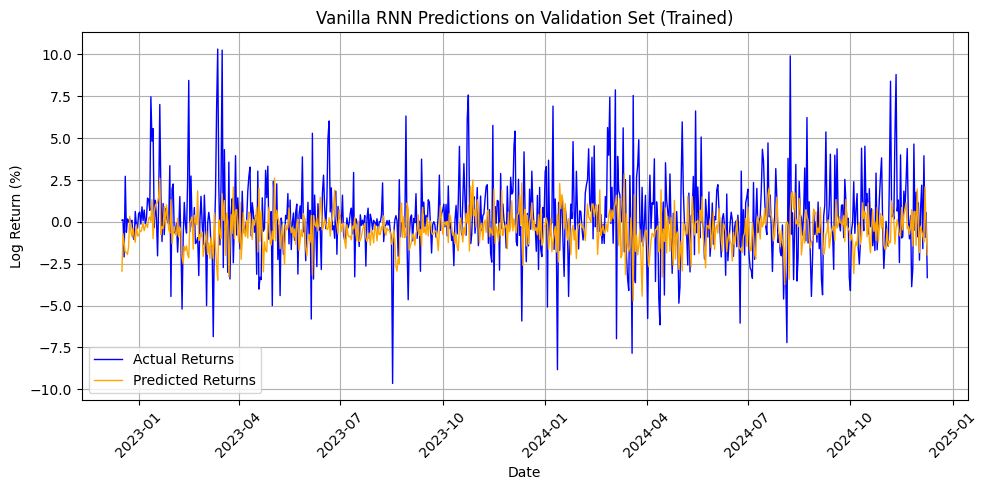

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------------------------
# Train / Val / Test Split
# ------------------------------
n = len(df)
train_end = int(n * 0.8)
val_end = int(n)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

# Now use lagged versions
feature_cols = [col for col in df.columns if col.startswith('lag_')]
target_col = 'log_return'

X_train, y_train = train[feature_cols], train[target_col]
X_val, y_val = val[feature_cols], val[target_col]

# ------------------------------
# Scaling
# ------------------------------
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = X_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))

# ------------------------------
# PyTorch Datasets & Loaders
# ------------------------------
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32)).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_scaled.astype(np.float32))

X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32)).unsqueeze(1)
y_val_tensor = torch.tensor(y_val_scaled.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# ------------------------------
# Vanilla RNN Model
# ------------------------------
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

input_size = X_train.shape[1]
model = VanillaRNN(input_size=input_size)

# ------------------------------
# Training Setup
# ------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

# ------------------------------
# Training Loop
# ------------------------------
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

# ------------------------------
# Evaluation on Validation Set
# ------------------------------
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred.item())
        actuals.append(y_batch.item())

predictions_inv = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals_inv = y_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

r2 = r2_score(actuals_inv, predictions_inv)
mae = mean_absolute_error(actuals_inv, predictions_inv)
rmse = np.sqrt(mean_squared_error(actuals_inv, predictions_inv))
print(f"R² Score on Validation Set (Vanilla RNN): {r2:.4f}")
print(f"MAE on Validation Set (Vanilla RNN): {mae:.4f}")
print(f"RMSE on Validation Set (Vanilla RNN): {rmse:.4f}")

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(10, 5))
plt.plot(y_val.index, actuals_inv, label='Actual Returns', color='blue', linewidth=1)
plt.plot(y_val.index, predictions_inv, label='Predicted Returns', color='orange', linewidth=1)
plt.title("Vanilla RNN Predictions on Validation Set (Trained)")
plt.xlabel("Date")
plt.ylabel("Log Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

df = btc.copy()

# Calculate log returns (in %)
df['log_return'] = 100 * np.log(df['close'] / df['close'].shift(1))

# Create lagged versions of the log return
n_lags = 10  # You can change this number to however many lags you want
for i in range(1, n_lags + 1):
    df[f'lag_{i}'] = df['log_return'].shift(i)

for col in ['close', 'open', 'high', 'low']:
    df[f'{col}_lag1'] = df[col].shift(1)

# Drop rows with NaN values (from shifting)
df.dropna(inplace=True)

print(df.tail())

           ticker      open      high      low     close  log_return  \
date                                                                   
2024-12-05    BTC   98298.2  104062.0  93081.3   96751.8   -1.599919   
2024-12-06    BTC   96789.0  102079.0  95560.6  100648.0    3.948034   
2024-12-07    BTC  100648.0  100724.0  99087.6   99717.7   -0.928609   
2024-12-08    BTC   99717.7  100548.0  98767.2  100276.0    0.558319   
2024-12-09    BTC  100264.0  101407.0  94879.2   96993.1   -3.328654   

               lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
date                                                                     
2024-12-05  2.195996  0.804355 -2.285890  1.141180 -0.893671  1.780346   
2024-12-06 -1.599919  2.195996  0.804355 -2.285890  1.141180 -0.893671   
2024-12-07  3.948034 -1.599919  2.195996  0.804355 -2.285890  1.141180   
2024-12-08 -0.928609  3.948034 -1.599919  2.195996  0.804355 -2.285890   
2024-12-09  0.558319 -0.928609  3.948034 -1.599919 

Epoch 1/80 - Loss: 1460.8173
Epoch 10/80 - Loss: 1388.0275
Epoch 20/80 - Loss: 1315.3276
Epoch 30/80 - Loss: 1239.6079
Epoch 40/80 - Loss: 1164.7616
Epoch 50/80 - Loss: 1104.2811
Epoch 60/80 - Loss: 1050.8054
Epoch 70/80 - Loss: 1000.9774
Epoch 80/80 - Loss: 957.1716
R² Score on Validation Set (LSTM): -0.2062
MAE on Validation Set (LSTM): 1.9231
RMSE on Validation Set (LSTM): 2.6962


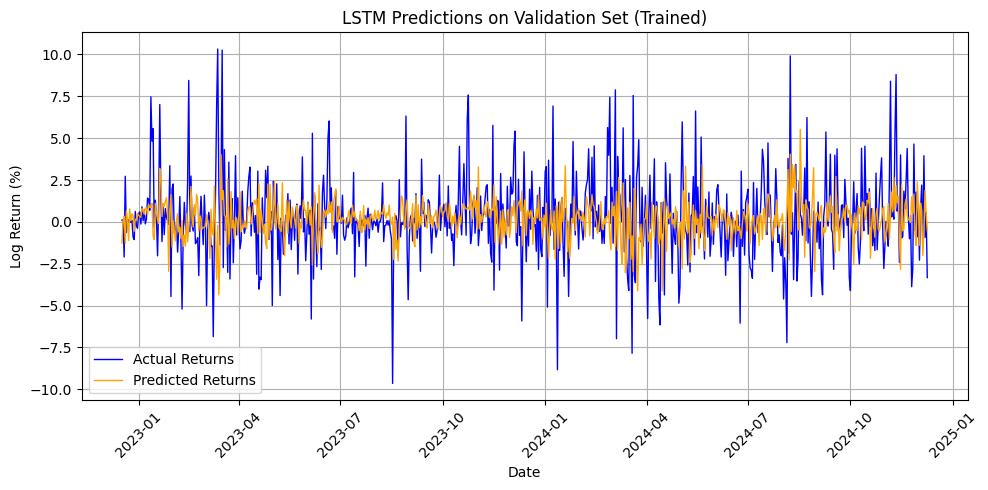

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

n = len(df)
train_end = int(n * 0.8)
val_end = int(n)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

feature_cols = [col for col in df.columns if col.startswith('lag_')]
target_col = 'log_return'

X_train, y_train = train[feature_cols], train[target_col]
X_val, y_val = val[feature_cols], val[target_col]

# ------------------------------
# Scaling
# ------------------------------
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = X_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))

# ------------------------------
# PyTorch Datasets & Loaders
# ------------------------------
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32)).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_scaled.astype(np.float32))

X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32)).unsqueeze(1)
y_val_tensor = torch.tensor(y_val_scaled.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# ------------------------------
# LSTM Model
# ------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

input_size = X_train.shape[1]
model = LSTMModel(input_size=input_size)

# ------------------------------
# Training Setup
# ------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
epochs = 80

# ------------------------------
# Training Loop
# ------------------------------
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

# ------------------------------
# Evaluation on Validation Set
# ------------------------------
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred.item())
        actuals.append(y_batch.item())

predictions_inv = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals_inv = y_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

r2 = r2_score(actuals_inv, predictions_inv)
mae = mean_absolute_error(actuals_inv, predictions_inv)
rmse = np.sqrt(mean_squared_error(actuals_inv, predictions_inv))
print(f"R² Score on Validation Set (LSTM): {r2:.4f}")
print(f"MAE on Validation Set (LSTM): {mae:.4f}")
print(f"RMSE on Validation Set (LSTM): {rmse:.4f}")

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(10, 5))
plt.plot(y_val.index, actuals_inv, label='Actual Returns', color='blue', linewidth=1)
plt.plot(y_val.index, predictions_inv, label='Predicted Returns', color='orange', linewidth=1)
plt.title("LSTM Predictions on Validation Set (Trained)")
plt.xlabel("Date")
plt.ylabel("Log Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Epoch 1/100 - Train Loss: 91.2167 - Val Loss: 0.4105
Epoch 10/100 - Train Loss: 90.0515 - Val Loss: 0.4115
Early stopping at epoch 13
R² Score on Validation Set (LSTM): -0.0117
MAE on Validation Set (LSTM): 1.7216
RMSE on Validation Set (LSTM): 2.4693


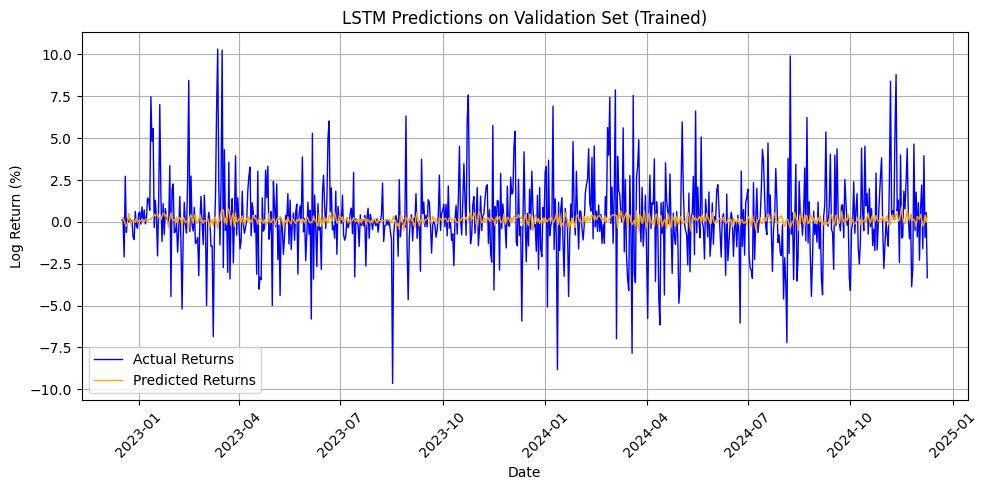

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------------------------
# Data Prep
# ------------------------------
n = len(df)
train_end = int(n * 0.8)

train = df.iloc[:train_end]
val = df.iloc[train_end:]

feature_cols = [col for col in df.columns if col.startswith('lag_')]
target_col = 'log_return'

X_train, y_train = train[feature_cols], train[target_col]
X_val, y_val = val[feature_cols], val[target_col]

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = X_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))

X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32)).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_scaled.astype(np.float32))

X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32)).unsqueeze(1)
y_val_tensor = torch.tensor(y_val_scaled.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ------------------------------
# LSTM Model
# ------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # last time step
        return self.fc(out)

input_size = X_train.shape[1]
model = LSTMModel(input_size=input_size)

# ------------------------------
# Training Setup
# ------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
epochs = 100
patience = 10

best_val_loss = float('inf')
trigger_times = 0

# ------------------------------
# Training Loop w/ Early Stopping
# ------------------------------
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()
    val_loss /= len(val_loader)

    # Print
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        best_model = model.state_dict()
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model)

# ------------------------------
# Evaluation
# ------------------------------
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        y_pred = model(X_batch)
        predictions.extend(y_pred.squeeze().tolist())
        actuals.extend(y_batch.squeeze().tolist())

# Inverse scale
predictions_inv = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals_inv = y_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

r2 = r2_score(actuals_inv, predictions_inv)
mae = mean_absolute_error(actuals_inv, predictions_inv)
rmse = np.sqrt(mean_squared_error(actuals_inv, predictions_inv))

print(f"R² Score on Validation Set (LSTM): {r2:.4f}")
print(f"MAE on Validation Set (LSTM): {mae:.4f}")
print(f"RMSE on Validation Set (LSTM): {rmse:.4f}")

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(10, 5))
plt.plot(y_val.index[-len(actuals_inv):], actuals_inv, label='Actual Returns', color='blue', linewidth=1)
plt.plot(y_val.index[-len(predictions_inv):], predictions_inv, label='Predicted Returns', color='orange', linewidth=1)
plt.title("LSTM Predictions on Validation Set (Trained)")
plt.xlabel("Date")
plt.ylabel("Log Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
